# Time series modelisation and prediction using SARIMA 

The aim of this project is to analyze and then to model a serie using [(S)ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) model for forecast
The serie studied "serie15", corresponds to a classical case of seasonal serie.

Technical report (in french) can be found [here](https://drive.google.com/file/d/1G9EtHYGYrhD1K3O4TQeBNYI_K9oOdhTm).

In [21]:
libname projet "./data_lib/";

## 0. Define macros

### Custom graph

In [27]:
%MACRO GRAPH(tab, var, titre);
    
    TITLE 'Evolution of the serie';
        PROC SGPLOT DATA = &tab.;
        SERIES X = t Y = &var.;
        XAXIS display=(nolabel);
        YAXIS label = &titre.;
    RUN;

%MEND GRAPH;

### Stationnarity Test

In [6]:
%MACRO TEST_STAT(tab, var, obs, thrsh);
    
    DATA tab_test_var;
        SET &tab.;
        ATTRIB group informat = $1. format = $1.;
        IF t <= round(&obs./3, 1) THEN group = "1";
        ELSE IF t >= round(2*&obs./3 + 1, 1) THEN group = "3";  
        ELSE group = "2";
    RUN;

    PROC MEANS DATA = tab_test_var var maxdec = 4 nonobs;
        VAR z;
        CLASS group;
    RUN;

    PROC TTEST DATA = tab_test_var (where = (group ^= "2")) alpha = &thrsh.;
        VAR z;
        CLASS group;
    RUN;
    QUIT;
%MEND TEST_STAT;

### Represent Autocorrelation Function

In [31]:
%MACRO ACF(tab, var, lag, titre);

    PROC ARIMA DATA = &tab.;
        i var= &var. nlag = &lag. outcov = cov_&var.;
    RUN;
    QUIT;
   
    TITLE 'ACF of serie';
    PROC SGPLOT DATA = cov_&var.;
        SERIES x = lag y = corr ;
        XAXIS display=(nolabel);
        YAXIS label = &titre.;
    RUN;
    
%MEND ACF;

### Seasonality test of Dickey-Fuller

In [7]:
%MACRO ADFS(tab,var,n,s,titre);
    PROC ARIMA DATA = &tab;
        i var=&var stationarity=(adf=&n dlag=&s);
        TITLE 'Dickey-Fuller seasonality test';
        TITLE2 &titre;
    RUN;
    QUIT;
%MEND ADFS;

## 1. Serie analysis and transformation

### Raw serie and stationarity test


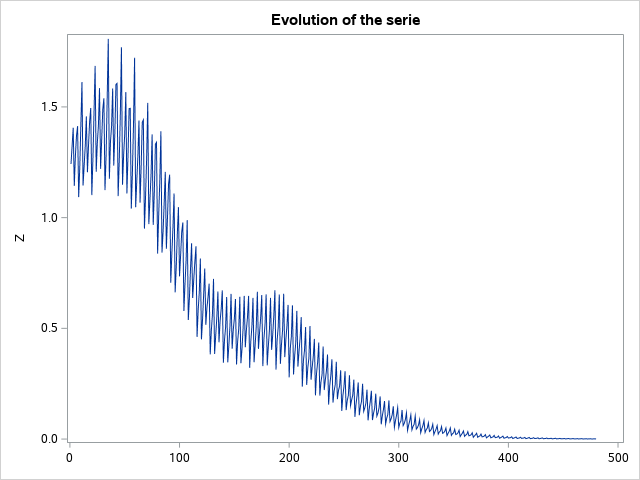

In [22]:
%GRAPH(projet.serie15, Z, "Z"); *Original serie;


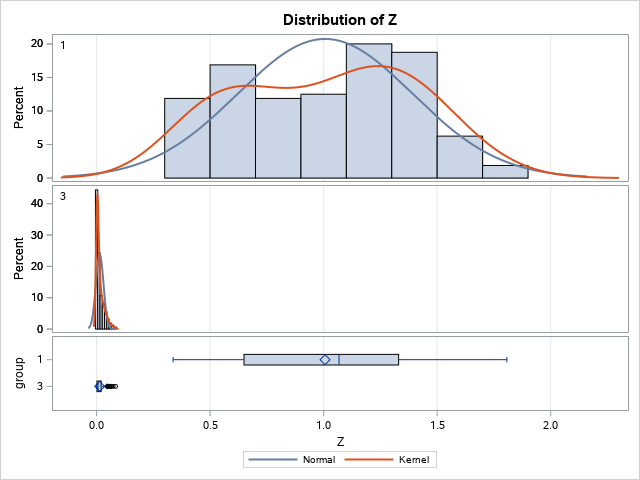
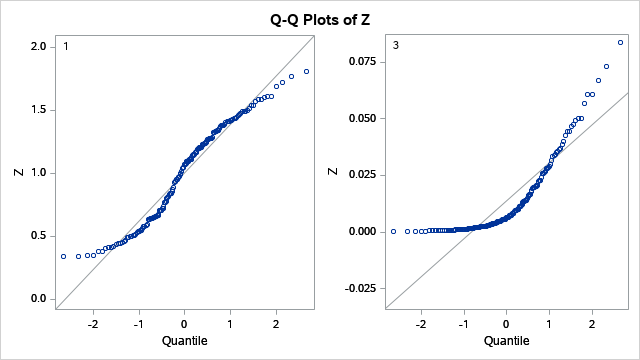

In [24]:
%TEST_STAT(projet.serie15, Z, 480, 0.05);  *===>  Non stationary serie , need variance stabilization;

### Variance stabilization using Box-Cox method


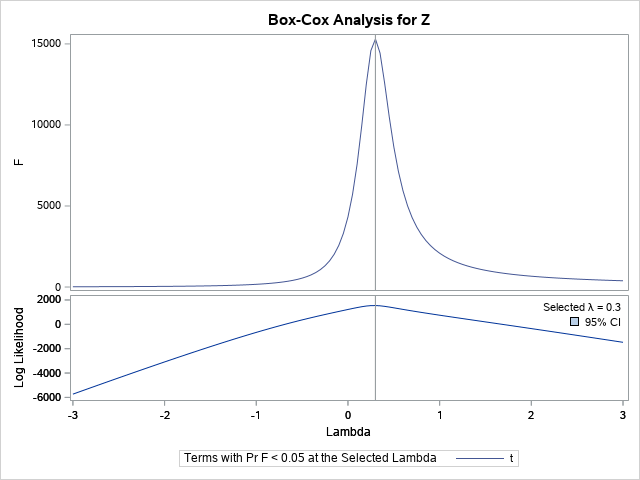
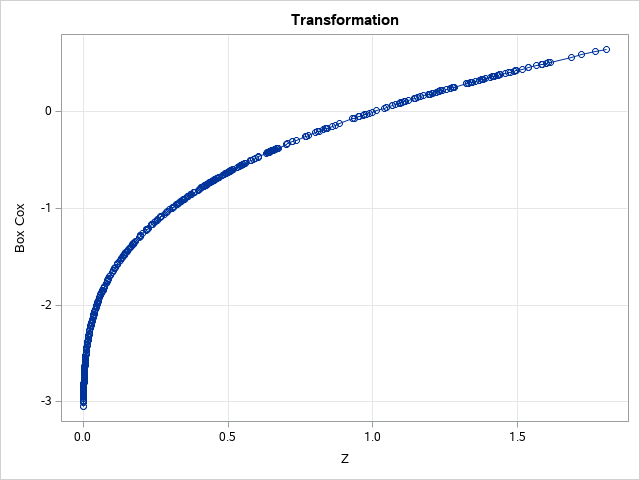
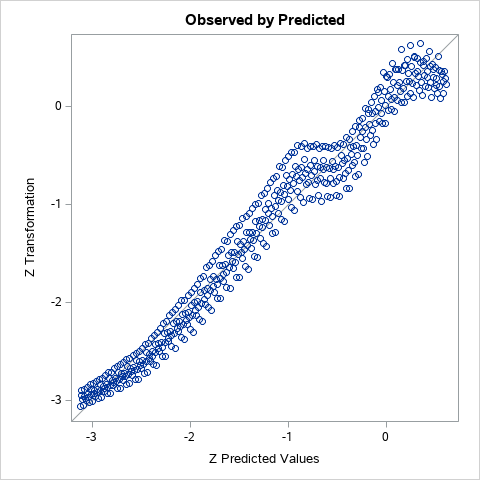

In [25]:
PROC TRANSREG details DATA = projet.serie15 ss2
    plots = (transformation(dependent) obp);
    MODEL boxcox(Z / convenient lambda = -3 to 3 by 0.05) = identity(t); * ===> the perfect lambda is 0.3;
    OUTPUT out=work.bcserie PREDICTED;
RUN;
QUIT;

DATA bcserie15;
    SET work.bcserie;
    ATTRIB BC_Z informat = 8.3 format = 8.3;
    BC_Z = TZ ;
RUN;

## 2. Variability modelisation

### Exploratory analysis of transformed serie


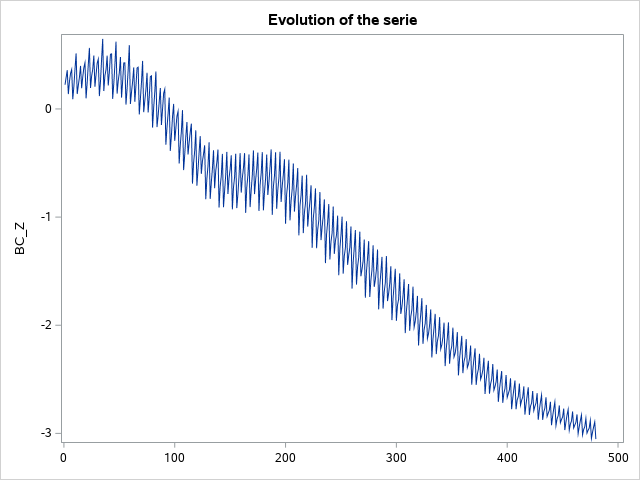

In [28]:
%graph(bcserie15, BC_Z, "BC_Z"); 


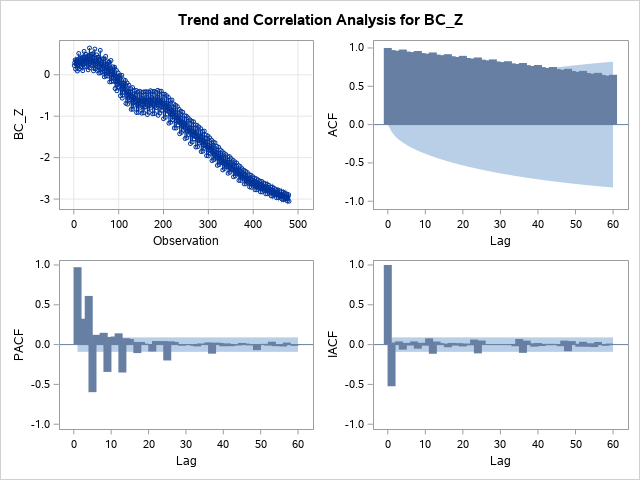
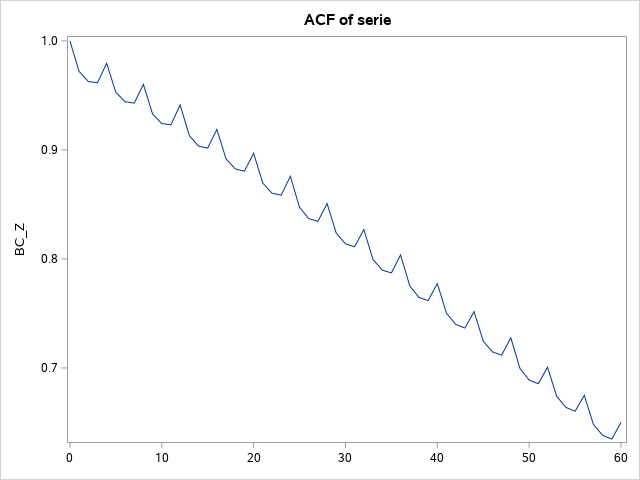

In [32]:
%ACF(bcserie15, BC_Z, 60, "BC_Z"); * ===> ACF slowly decreasing and of periodicity 4;

### Trend elimination using differentiation


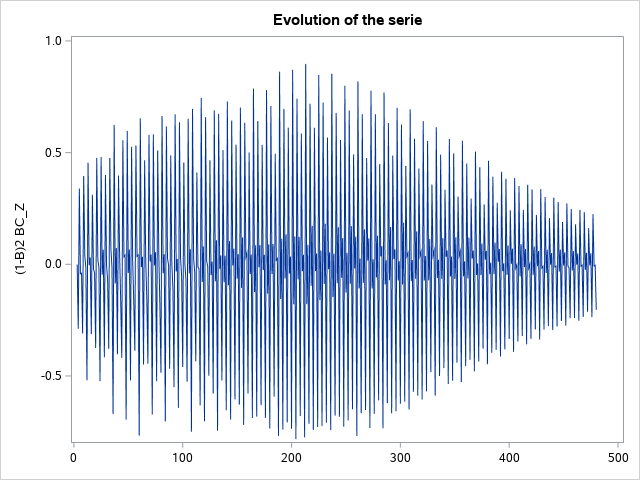
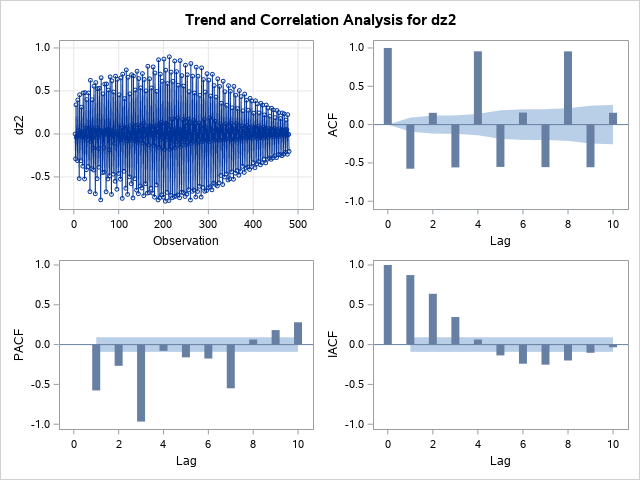
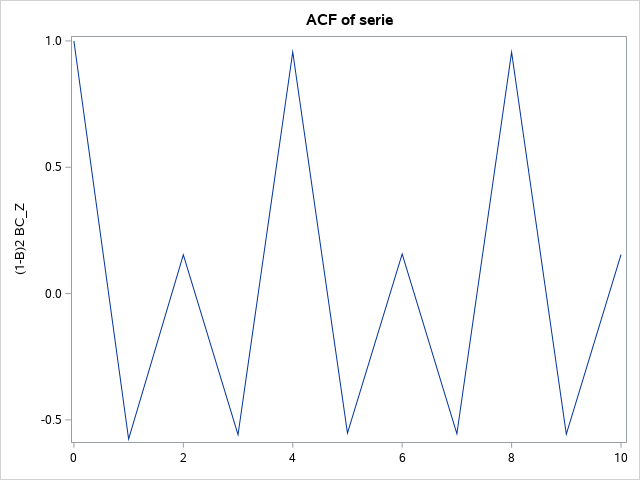
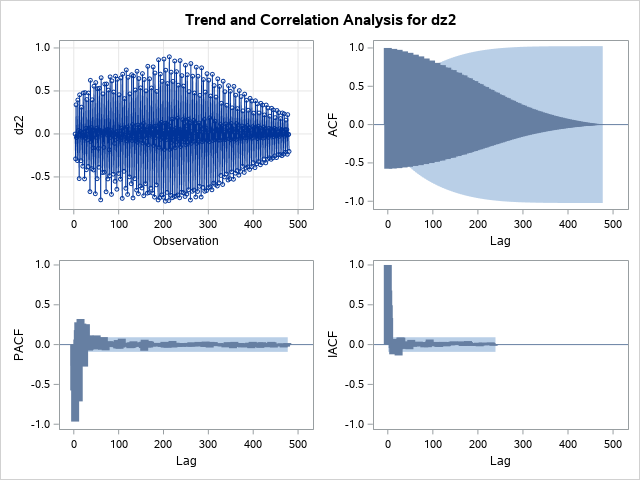
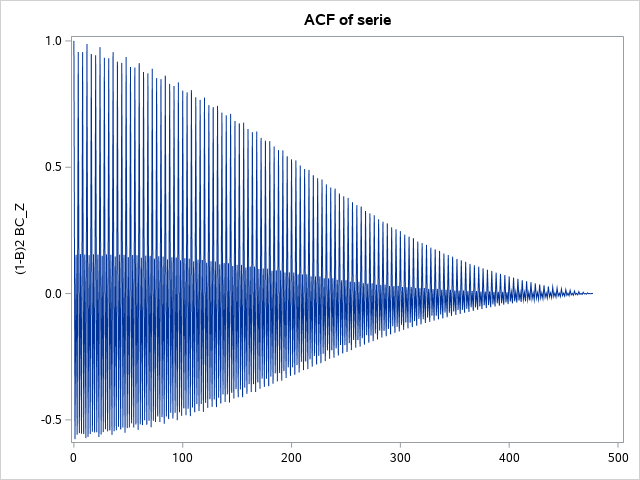

In [34]:
DATA bcserie15diff;
    SET bcserie15;
    ATTRIB dz2 informat = 8.3 format = 8.3;
    dz2 = dif((dif(BC_Z))); *====> Delta(2) est adaptée;
RUN;


%graph(bcserie15diff, dz2, "(1-B)2 BC_Z"); * Serie after Trends elemination;
%ACF(bcserie15diff, dz2, 10, "(1-B)2 BC_Z");
%ACF(bcserie15diff, dz2, 480, "(1-B)2 BC_Z");

### Seasonality elemination using Season Difference


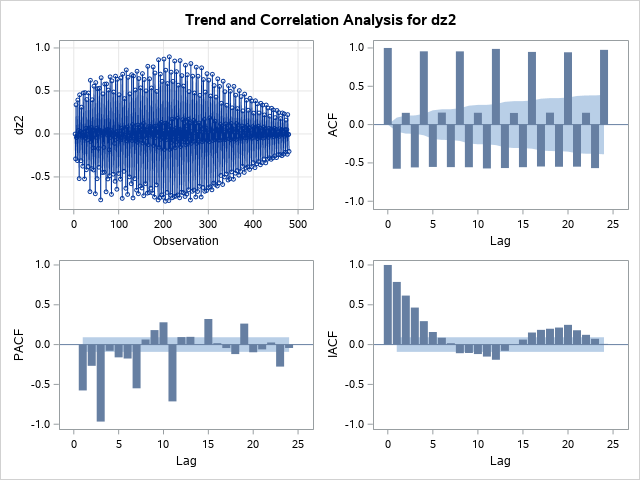

In [36]:
%adfs(bcserie15diff,dz2,10,10,'(1-B)2 BC_Z'); * ADF test of 10 order;

* ====> Find unitary square of seasonality 4 ;

* Seasonality difference;
DATA bcserie15diff2;
    SET bcserie15diff;
    ATTRIB dz6 informat = 8.3 format = 8.3;
    dz6 = dif4(dz2); * Ordre 4;
RUN;

### Analysis of the serie without trends and saisonality


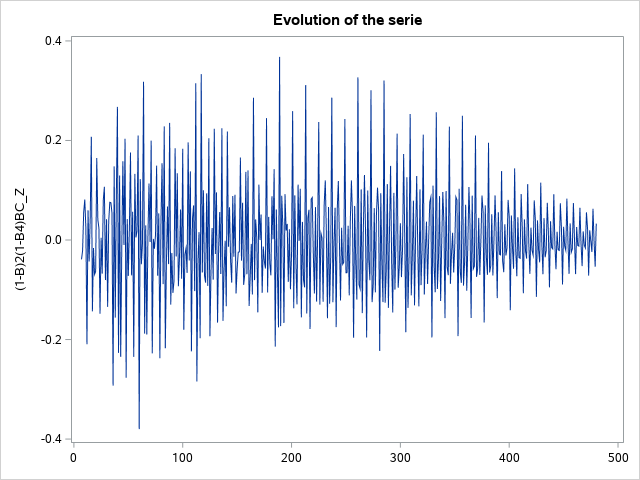
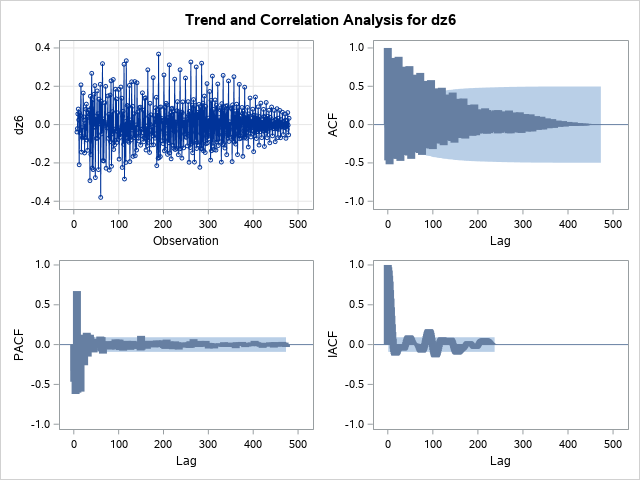
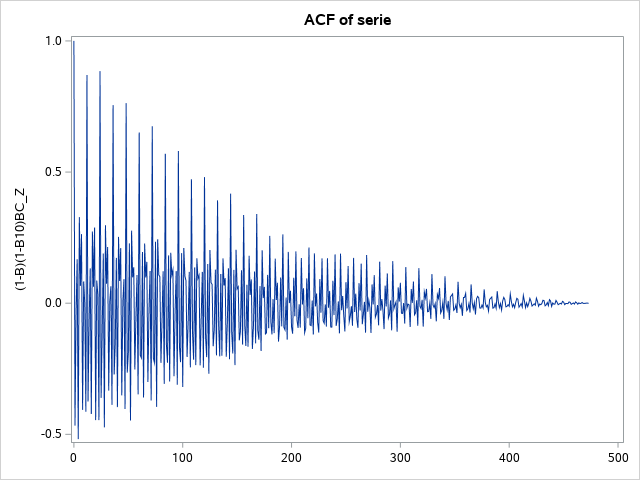
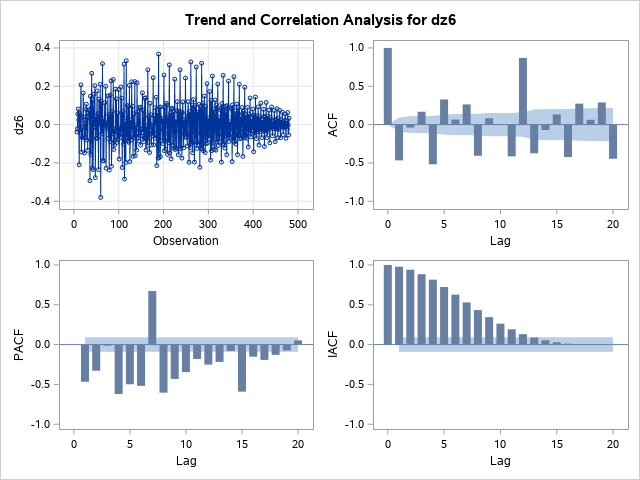
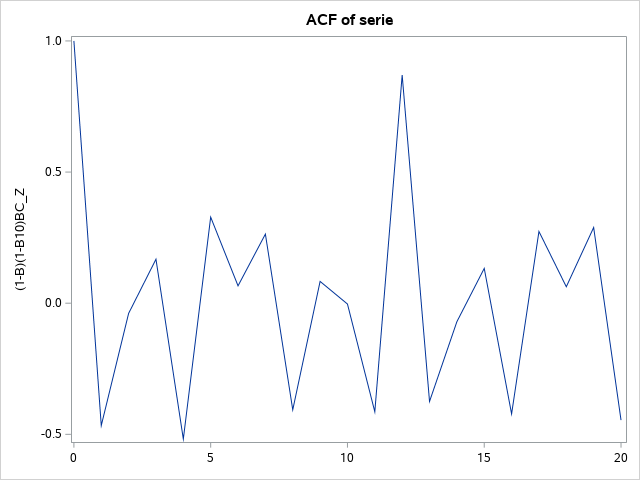

In [37]:
%graph(bcserie15diff2, dz6, "(1-B)2(1-B4)BC_Z");

%ACF(bcserie15diff2, dz6, 480, "(1-B)(1-B10)BC_Z");
%ACF(bcserie15diff2, dz6, 20, "(1-B)(1-B10)BC_Z");

### 3. SARIMA modelisation and forecast

### Modelisation of original serie 


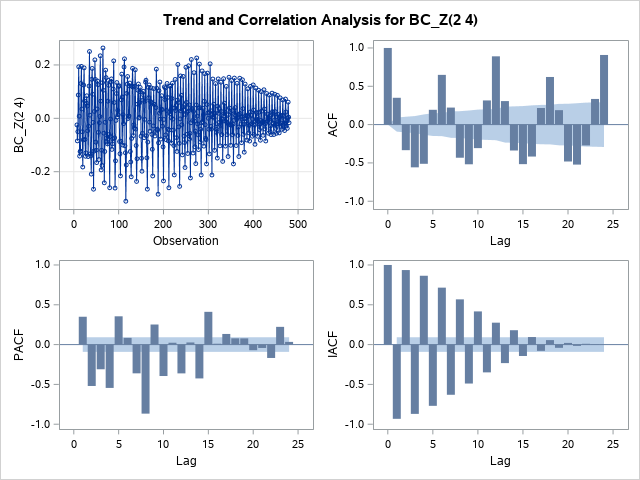
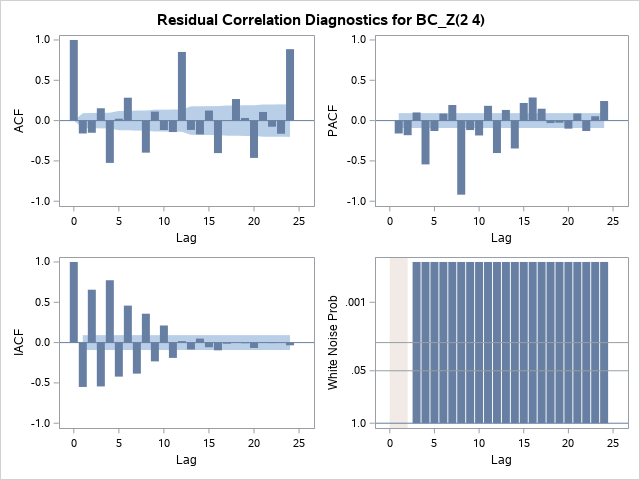
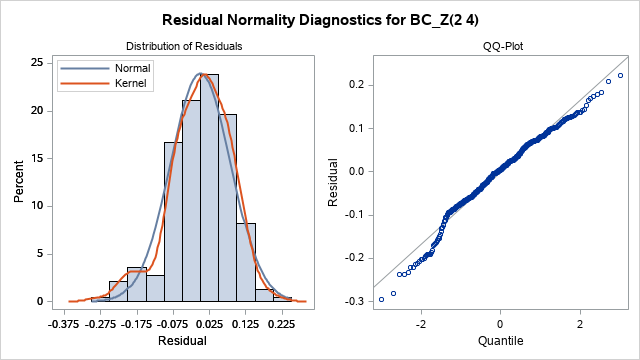
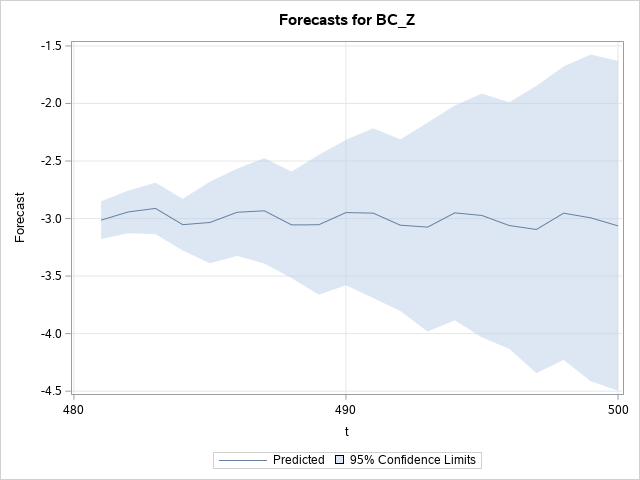

In [39]:
* PROC SARIMA is done to the transformed serie (Box-Cox);

PROC ARIMA DATA = bcserie15;
    identify var = BC_Z(2,4); * Diff=3 et delta=4;
    estimate  p=2 q=0  method=ml;
    forecast lead=20 id=t out=bcserie15fc;
RUN;
QUIT;

DATA selecbcserie15fc ;
    set work.bcserie15fc ;
    if t > 480 ;
RUN;


### Compare forecast with real data


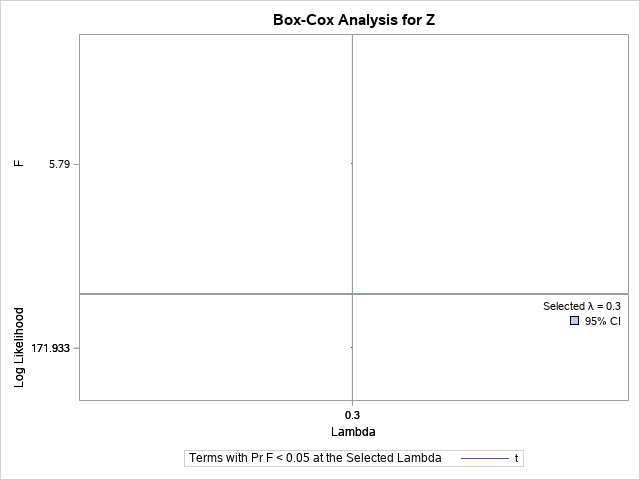
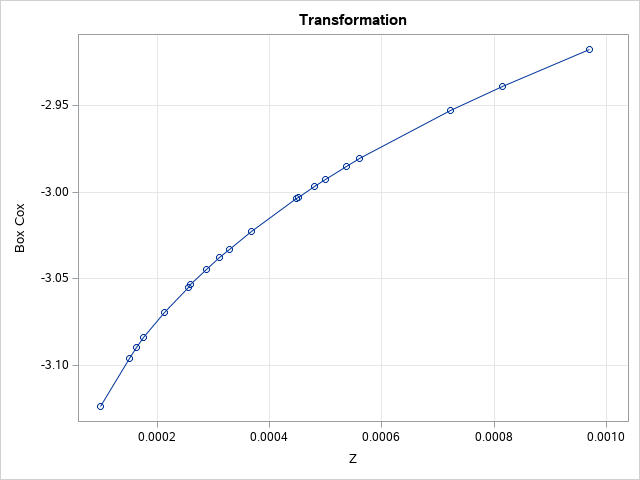
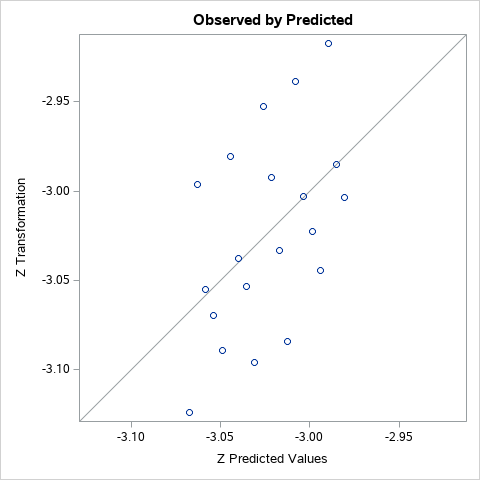
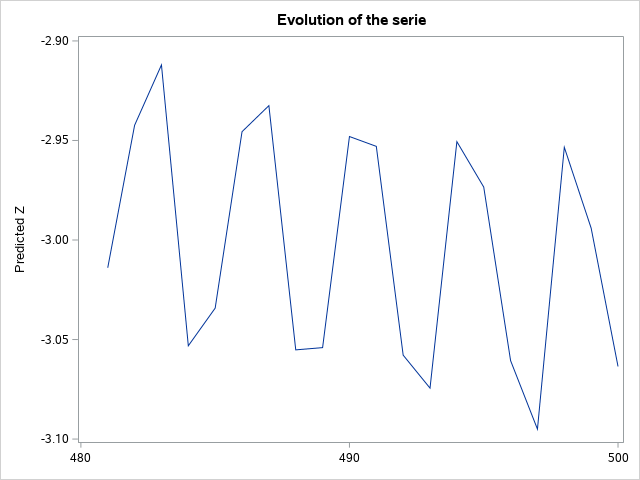
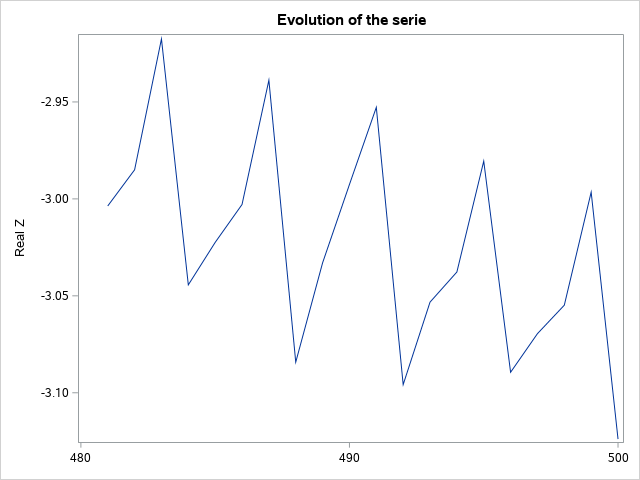

In [41]:
* Transformation box cox of test data;
PROC TRANSREG details data = projet.prev15 ss2
    plots = (transformation(dependent) obp);
    MODEL boxcox(Z /  lambda = 0.3) = identity(t); 
    OUTPUT out=work.bcprev15 PREDICTED;
RUN;
QUIT;

%graph(selecbcserie15fc, FORECAST, "Predicted Z"); 
%graph(bcprev15, TZ, "Real Z"); 